# MODELO ARIMA 

Un modelo ARIMA(p,d,q) se define por tres parámetros:

    p: Orden autoregresivo (autoregressive order)
    d: Orden de diferencia (difference order)
    q: Orden de media móvil (moving average order)

El test estadístico que se emplea para verificar la estacionaridad de una serie temporal es el test Augmented Dickey-Fuller.

Las hipótesis de este test son:

    H₀ (Hipótesis nula) = La serie temporal no es estacionaria
    H₁ (Hipótesis alternativa) = La serie temporal es estacionaria

 Definir un nivel de significancia a, que generalmete tiene un valor de 0.05. Esto se usa para compararlo con el valor p (p-value) del test. Por un lado, si el p valor del test es mayor que el nivel de significancia, fallaríamos en rechazar la hipótesis nula, lo que significa que serie temporal no seríá estacionaria. Por otro lado, si el p valor es menor que le nivel de significancia, rechazaremos la hipótesis nula, lo que significa que nuestra serie temporal se puede considerar estacionaria.

 Para elegir d haremos ese test en los datos de la serie temporal. Si podemos concluir que es estacionaria entonce d valdrá 0. Si no lo es, necesitaremos aplicar una transformación de diferenciación y volver a realizar el test. Si tras una diferenciación nuestra serie temporal se vuelve estacionaria, d valdrá 1. Este proceso se repetirá tantas veces como sea necesarias hasta definir d.

 ¿Cómo estimamos p y q?

Necesitamos comprobar cómo de correlada esta la serie temporal con versiones lagged (retrasadas) de sí misma.

A la serie temporal original se refiere como 0. Una versión retrasada 1 paso temporal se refiere como 1, y así todas. La correlación con la serie temporal original con retraso de 0 (sin retraso), siempre valdrá 1 ya que son la misma serie temporal.

Necesitamos diferenciar dos correlaciones:

    La correlación indirecta que los pasos temporales t-1, t-2, t-3… tienen sobre el paso temporal t simplemente por ser adyacentes los unos a los otros. Por ejemplo, con valores de acciones, el precio de hoy vendrá influenciado por el precio que tuvo ayer y, por lo tanto, el precio de ayer tiene relación con el precio que tuvo anteayer.
    La correlación directa que cada uno de los pasos temporales anteriores tiene con el paso temporal t. Continuando con el mismo ejemplo, imagina que cada tres días hay un evento especial, es de esperar que veremos una correlación directa con la serie temporal retrasada 3 pasos.

Para medir estos efectos podemos usar los gráficos ACF y PACF:

    ACF Función de autocorrelación (AutoCorrelation Function) muestra la correlación entre pasos temporales. Incluye los efectos directos e indirectos
    PACF Función parcial de autocorrelación (Partial AutoCorrelation Function) muestra sólo la correlación directa
    
Hay varias líneas o «piruletas» en ellos. Las piruletas indican la correlación en cada retraso (en el eje X) respecto a la serie temporal original. Necesitamos prestar atención a las piruletas más altas cerca del retraso 0 que están fuera de la zona azul. Si una piruleta está en este área, esto significa que la correlación no es significativamente respecto al 0 y, por lo tanto, no es relevante.

    Para el parámetro p que determina cuántos valores anteriores tendremos en cuenta para la parte AR de ARIMA, necesitamos comprobar el gráfico PACF ya que estamos interesados en la correlación directa
    Para el parámetro q que determina cuántos residuos (errores) anteriores necesitamos tener en cuenta para la media móvil, necesitamos mirar el gráfico ACF ya que buscamos principalmente la correlación indirecta




In [1]:
!pip install pmdarima

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)


In [3]:
df = pd.read_csv('../data/calidad_clean_outliers.csv', delimiter=',')
df.head(2)

,FECHA,ANO,MES,DIA,HORA,DIA_SEMANA,ESTACION,SO2,CO,NO2,PM2.5,PM10,O3,BTX,TEMPERATURA,HUMEDAD,ICA_SO2,ICA_PM10,ICA_O3,ICA_NO2,ICA
0,2019-01-01 05:00:00,2019.0,1.0,1.0,5,Martes,8.0,10.0,0.4,50.0,14.0,19.0,11.88,2.6,4.7,50.0,8.0,38.0,9.90,125.0,45.22
1,2019-01-01 06:00:00,2019.0,1.0,1.0,6,Martes,8.0,8.0,0.4,55.0,12.0,16.0,7.97,2.2,3.2,55.0,6.4,32.0,6.64,137.5,45.64


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30860 entries, 0 to 30859
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   FECHA        30860 non-null  object 
 1   ANO          30860 non-null  float64
 2   MES          30860 non-null  float64
 3   DIA          30860 non-null  float64
 4   HORA         30860 non-null  int64  
 5   DIA_SEMANA   30860 non-null  object 
 6   ESTACION     30860 non-null  float64
 7   SO2          30860 non-null  float64
 8   CO           30860 non-null  float64
 9   NO2          30860 non-null  float64
 10  PM2.5        30860 non-null  float64
 11  PM10         30860 non-null  float64
 12  O3           30860 non-null  float64
 13  BTX          30860 non-null  float64
 14  TEMPERATURA  30860 non-null  float64
 15  HUMEDAD      30860 non-null  float64
 16  ICA_SO2      30860 non-null  float64
 17  ICA_PM10     30860 non-null  float64
 18  ICA_O3       30860 non-null  float64
 19  ICA_

In [5]:
df.FECHA = pd.to_datetime(df.FECHA)

In [6]:
df = df.set_index('FECHA')
df.head(2)

,ANO,MES,DIA,HORA,DIA_SEMANA,ESTACION,SO2,CO,NO2,PM2.5,PM10,O3,BTX,TEMPERATURA,HUMEDAD,ICA_SO2,ICA_PM10,ICA_O3,ICA_NO2,ICA
FECHA,,,,,,,,,,,,,,,,,,,,
2019-01-01 05:00:00,2019.0,1.0,1.0,5,Martes,8.0,10.0,0.4,50.0,14.0,19.0,11.88,2.6,4.7,50.0,8.0,38.0,9.90,125.0,45.22
2019-01-01 06:00:00,2019.0,1.0,1.0,6,Martes,8.0,8.0,0.4,55.0,12.0,16.0,7.97,2.2,3.2,55.0,6.4,32.0,6.64,137.5,45.64


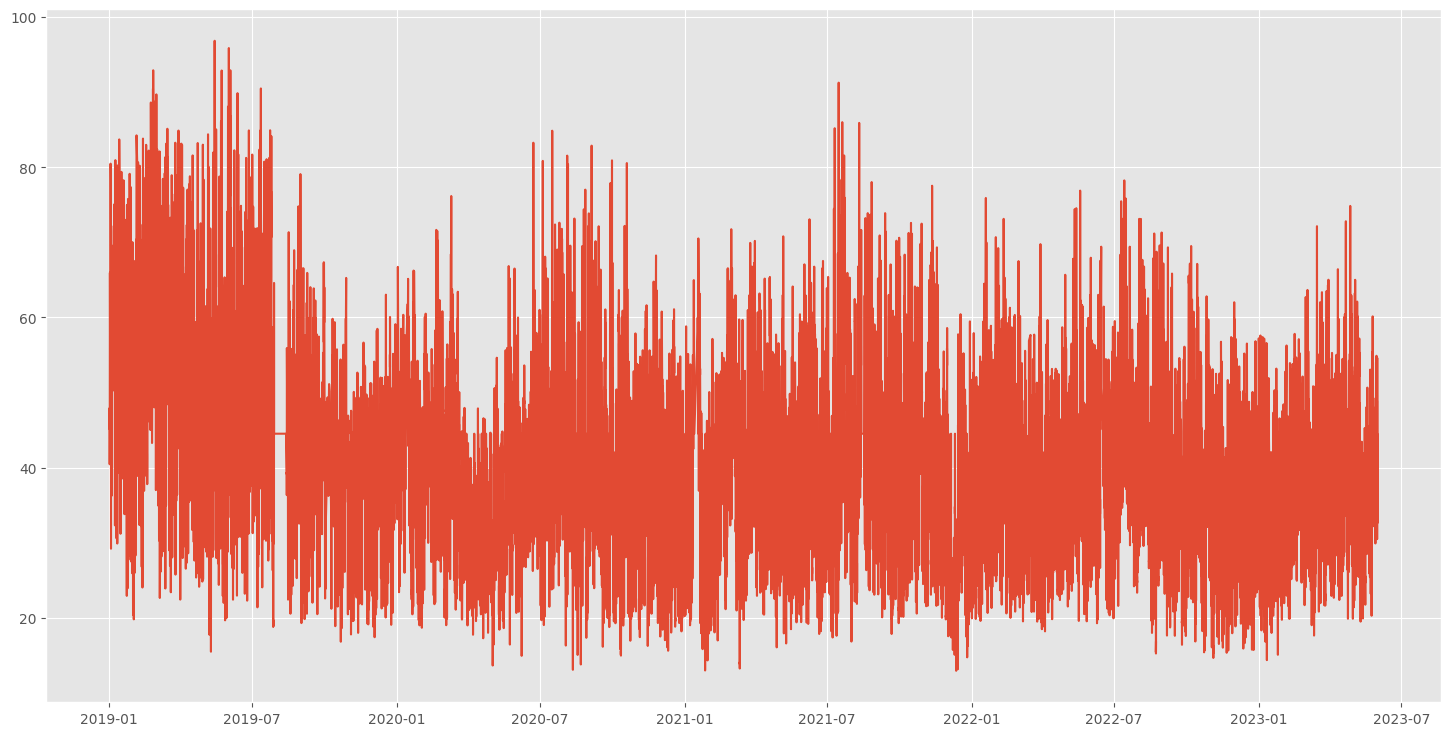

In [7]:
plt.figure(figsize=(18,9))
plt.plot(df.index,df['ICA'], linestyle='-')
plt.xlabel=('FECHA')
plt.ylabel=('Mediciones ICA')
plt.show();

In [8]:
df = pd.read_csv('../data/calidad_clean_outliers.csv', delimiter=',')

In [9]:
df.reset_index(drop=True, inplace=True)

In [10]:
df.columns

Index(['FECHA', 'ANO', 'MES', 'DIA', 'HORA', 'DIA_SEMANA', 'ESTACION', 'SO2',
       'CO', 'NO2', 'PM2.5', 'PM10', 'O3', 'BTX', 'TEMPERATURA', 'HUMEDAD',
       'ICA_SO2', 'ICA_PM10', 'ICA_O3', 'ICA_NO2', 'ICA'],
      dtype='object')

In [11]:
lag_features = ['SO2', 'PM10', 'O3', 'NO2', 'CO', 'PM2.5', 'BTX', 'TEMPERATURA', 'HUMEDAD']
window1 =3
window2 =7
window30 =30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window30, min_periods=0)



In [12]:
df_mean_3d =df_rolled_3d.mean().shift(1).reset_index()
df_mean_7d =df_rolled_7d.mean().shift(1).reset_index()
df_mean_30d =df_rolled_30d.mean().shift(1).reset_index()

df_std_3d =df_rolled_3d.std().shift(1).reset_index()
df_std_7d =df_rolled_7d.std().shift(1).reset_index()
df_std_30d =df_rolled_30d.std().shift(1).reset_index()

In [13]:
for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window30}"] = df_mean_30d[feature]
    
    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window30}"] = df_std_30d[feature]
    
df.fillna(df.mean(), inplace=True)

In [14]:
df.head(3)

,FECHA,ANO,MES,DIA,HORA,DIA_SEMANA,ESTACION,SO2,CO,NO2,PM2.5,PM10,O3,BTX,TEMPERATURA,HUMEDAD,ICA_SO2,ICA_PM10,ICA_O3,ICA_NO2,ICA,SO2_mean_lag3,SO2_mean_lag7,SO2_mean_lag30,SO2_std_lag3,SO2_std_lag7,SO2_std_lag30,PM10_mean_lag3,PM10_mean_lag7,PM10_mean_lag30,PM10_std_lag3,PM10_std_lag7,PM10_std_lag30,O3_mean_lag3,O3_mean_lag7,O3_mean_lag30,O3_std_lag3,O3_std_lag7,O3_std_lag30,NO2_mean_lag3,NO2_mean_lag7,NO2_mean_lag30,NO2_std_lag3,NO2_std_lag7,NO2_std_lag30,CO_mean_lag3,CO_mean_lag7,CO_mean_lag30,CO_std_lag3,CO_std_lag7,CO_std_lag30,PM2.5_mean_lag3,PM2.5_mean_lag7,PM2.5_mean_lag30,PM2.5_std_lag3,PM2.5_std_lag7,PM2.5_std_lag30,BTX_mean_lag3,BTX_mean_lag7,BTX_mean_lag30,BTX_std_lag3,BTX_std_lag7,BTX_std_lag30,TEMPERATURA_mean_lag3,TEMPERATURA_mean_lag7,TEMPERATURA_mean_lag30,TEMPERATURA_std_lag3,TEMPERATURA_std_lag7,TEMPERATURA_std_lag30,HUMEDAD_mean_lag3,HUMEDAD_mean_lag7,HUMEDAD_mean_lag30,HUMEDAD_std_lag3,HUMEDAD_std_lag7,HUMEDAD_std_lag30
0,2019-01-01 05:00:00,2019.0,1.0,1.0,5,Martes,8.0,10.0,0.4,50.0,14.0,19.0,11.88,2.6,4.7,50.0,8.0,38.0,9.90,125.0,45.22,4.846384,4.846926,4.850459,0.223876,0.359950,0.556813,15.065905,15.066464,15.066382,3.817364,4.915721,6.300724,53.302134,53.29689,53.278322,7.253006,11.972212,17.425041,31.528568,31.530346,31.539496,6.080555,9.648324,13.011966,0.246473,0.246477,0.2465,0.026648,0.043491,0.058241,7.771851,7.772607,7.773437,2.689900,3.301417,4.009906,2.275411,2.275505,2.27586,0.493789,0.729653,1.022830,16.422463,16.42123,16.41618,1.126006,2.146563,3.64619,54.963912,54.964179,54.958693,3.708078,6.890693,12.200754
1,2019-01-01 06:00:00,2019.0,1.0,1.0,6,Martes,8.0,8.0,0.4,55.0,12.0,16.0,7.97,2.2,3.2,55.0,6.4,32.0,6.64,137.5,45.64,10.000000,10.000000,10.000000,0.223876,0.359950,0.556813,19.000000,19.000000,19.000000,3.817364,4.915721,6.300724,11.880000,11.88000,11.880000,7.253006,11.972212,17.425041,50.000000,50.000000,50.000000,6.080555,9.648324,13.011966,0.400000,0.400000,0.4000,0.026648,0.043491,0.058241,14.000000,14.000000,14.000000,2.689900,3.301417,4.009906,2.600000,2.600000,2.60000,0.493789,0.729653,1.022830,4.700000,4.70000,4.70000,1.126006,2.146563,3.64619,50.000000,50.000000,50.000000,3.708078,6.890693,12.200754
2,2019-01-01 07:00:00,2019.0,1.0,1.0,7,Martes,8.0,10.0,0.4,56.0,14.0,18.0,9.32,2.5,4.0,51.0,8.0,36.0,7.77,140.0,47.94,9.000000,9.000000,9.000000,1.414214,1.414214,1.414214,17.500000,17.500000,17.500000,2.121320,2.121320,2.121320,9.925000,9.92500,9.925000,2.764788,2.764788,2.764788,52.500000,52.500000,52.500000,3.535534,3.535534,3.535534,0.400000,0.400000,0.4000,0.000000,0.000000,0.000000,13.000000,13.000000,13.000000,1.414214,1.414214,1.414214,2.400000,2.400000,2.40000,0.282843,0.282843,0.282843,3.950000,3.95000,3.95000,1.060660,1.060660,1.06066,52.500000,52.500000,52.500000,3.535534,3.535534,3.535534


In [15]:
df.FECHA = pd.to_datetime(df.FECHA)

In [16]:
df['MONTH'] = df.FECHA.dt.month
df['WEEK'] = df.FECHA.dt.week
df['DAY'] = df.FECHA.dt.day
df['DAY_OF_WEEK'] = df.FECHA.dt.day_of_week
df.head(3)

,FECHA,ANO,MES,DIA,HORA,DIA_SEMANA,ESTACION,SO2,CO,NO2,PM2.5,PM10,O3,BTX,TEMPERATURA,HUMEDAD,ICA_SO2,ICA_PM10,ICA_O3,ICA_NO2,ICA,SO2_mean_lag3,SO2_mean_lag7,SO2_mean_lag30,SO2_std_lag3,SO2_std_lag7,SO2_std_lag30,PM10_mean_lag3,PM10_mean_lag7,PM10_mean_lag30,PM10_std_lag3,PM10_std_lag7,PM10_std_lag30,O3_mean_lag3,O3_mean_lag7,O3_mean_lag30,O3_std_lag3,O3_std_lag7,O3_std_lag30,NO2_mean_lag3,NO2_mean_lag7,NO2_mean_lag30,NO2_std_lag3,NO2_std_lag7,NO2_std_lag30,CO_mean_lag3,CO_mean_lag7,CO_mean_lag30,CO_std_lag3,CO_std_lag7,CO_std_lag30,PM2.5_mean_lag3,PM2.5_mean_lag7,PM2.5_mean_lag30,PM2.5_std_lag3,PM2.5_std_lag7,PM2.5_std_lag30,BTX_mean_lag3,BTX_mean_lag7,BTX_mean_lag30,BTX_std_lag3,BTX_std_lag7,BTX_std_lag30,TEMPERATURA_mean_lag3,TEMPERATURA_mean_lag7,TEMPERATURA_mean_lag30,TEMPERATURA_std_lag3,TEMPERATURA_std_lag7,TEMPERATURA_std_lag30,HUMEDAD_mean_lag3,HUMEDAD_mean_lag7,HUMEDAD_mean_lag30,HUMEDAD_std_lag3,HUMEDAD_std_lag7,HUMEDAD_std_lag30,MONTH,WEEK,DAY,DAY_OF_WEEK
0,2019-01-01 05:00:00,2019.0,1.0,1.0,5,Martes,8.0,10.0,0.4,50.0,14.0,19.0,11.88,2.6,4.7,50.0,8.0,38.0,9.90,125.0,45.22,4.846384,4.846926,4.850459,0.223876,0.359950,0.556813,15.065905,15.066464,15.066382,3.817364,4.915721,6.300724,53.302134,53.29689,53.278322,7.253006,11.972212,17.425041,31.528568,31.530346,31.539496,6.080555,9.648324,13.011966,0.246473,0.246477,0.2465,0.026648,0.043491,0.058241,7.771851,7.772607,7.773437,2.689900,3.301417,4.009906,2.275411,2.275505,2.27586,0.493789,0.729653,1.022830,16.422463,16.42123,16.41618,1.126006,2.146563,3.64619,54.963912,54.964179,54.958693,3.708078,6.890693,12.200754,1,1,1,1
1,2019-01-01 06:00:00,2019.0,1.0,1.0,6,Martes,8.0,8.0,0.4,55.0,12.0,16.0,7.97,2.2,3.2,55.0,6.4,32.0,6.64,137.5,45.64,10.000000,10.000000,10.000000,0.223876,0.359950,0.556813,19.000000,19.000000,19.000000,3.817364,4.915721,6.300724,11.880000,11.88000,11.880000,7.253006,11.972212,17.425041,50.000000,50.000000,50.000000,6.080555,9.648324,13.011966,0.400000,0.400000,0.4000,0.026648,0.043491,0.058241,14.000000,14.000000,14.000000,2.689900,3.301417,4.009906,2.600000,2.600000,2.60000,0.493789,0.729653,1.022830,4.700000,4.70000,4.70000,1.126006,2.146563,3.64619,50.000000,50.000000,50.000000,3.708078,6.890693,12.200754,1,1,1,1
2,2019-01-01 07:00:00,2019.0,1.0,1.0,7,Martes,8.0,10.0,0.4,56.0,14.0,18.0,9.32,2.5,4.0,51.0,8.0,36.0,7.77,140.0,47.94,9.000000,9.000000,9.000000,1.414214,1.414214,1.414214,17.500000,17.500000,17.500000,2.121320,2.121320,2.121320,9.925000,9.92500,9.925000,2.764788,2.764788,2.764788,52.500000,52.500000,52.500000,3.535534,3.535534,3.535534,0.400000,0.400000,0.4000,0.000000,0.000000,0.000000,13.000000,13.000000,13.000000,1.414214,1.414214,1.414214,2.400000,2.400000,2.40000,0.282843,0.282843,0.282843,3.950000,3.95000,3.95000,1.060660,1.060660,1.06066,52.500000,52.500000,52.500000,3.535534,3.535534,3.535534,1,1,1,1


In [17]:
df_train = df[df.FECHA < '2023']
df_valid = df[df.FECHA >= '2023']

In [18]:
df_train.tail(3)

,FECHA,ANO,MES,DIA,HORA,DIA_SEMANA,ESTACION,SO2,CO,NO2,PM2.5,PM10,O3,BTX,TEMPERATURA,HUMEDAD,ICA_SO2,ICA_PM10,ICA_O3,ICA_NO2,ICA,SO2_mean_lag3,SO2_mean_lag7,SO2_mean_lag30,SO2_std_lag3,SO2_std_lag7,SO2_std_lag30,PM10_mean_lag3,PM10_mean_lag7,PM10_mean_lag30,PM10_std_lag3,PM10_std_lag7,PM10_std_lag30,O3_mean_lag3,O3_mean_lag7,O3_mean_lag30,O3_std_lag3,O3_std_lag7,O3_std_lag30,NO2_mean_lag3,NO2_mean_lag7,NO2_mean_lag30,NO2_std_lag3,NO2_std_lag7,NO2_std_lag30,CO_mean_lag3,CO_mean_lag7,CO_mean_lag30,CO_std_lag3,CO_std_lag7,CO_std_lag30,PM2.5_mean_lag3,PM2.5_mean_lag7,PM2.5_mean_lag30,PM2.5_std_lag3,PM2.5_std_lag7,PM2.5_std_lag30,BTX_mean_lag3,BTX_mean_lag7,BTX_mean_lag30,BTX_std_lag3,BTX_std_lag7,BTX_std_lag30,TEMPERATURA_mean_lag3,TEMPERATURA_mean_lag7,TEMPERATURA_mean_lag30,TEMPERATURA_std_lag3,TEMPERATURA_std_lag7,TEMPERATURA_std_lag30,HUMEDAD_mean_lag3,HUMEDAD_mean_lag7,HUMEDAD_mean_lag30,HUMEDAD_std_lag3,HUMEDAD_std_lag7,HUMEDAD_std_lag30,MONTH,WEEK,DAY,DAY_OF_WEEK
27947,2022-12-31 18:00:00,2022.0,12.0,31.0,18,Sabado,8.0,2.0,0.3,37.0,14.0,31.0,30.44,0.3,11.6,50.0,1.6,62.0,25.37,92.5,45.37,2.0,2.428571,2.1,0.0,0.534522,0.305129,26.666667,23.857143,18.333333,1.527525,4.099942,4.459266,56.653333,44.605714,28.004000,4.709696,12.417709,16.438530,15.000000,24.000000,37.466667,3.605551,8.736895,11.294592,0.233333,0.285714,0.350000,0.057735,0.069007,0.062972,10.000000,10.857143,8.566667,2.00000,2.193063,2.582211,0.466667,0.785714,1.083333,0.208167,0.353217,0.374243,15.033333,14.628571,10.893333,1.159023,1.750918,3.173373,40.0,47.857143,66.933333,3.605551,9.581729,12.632561,12,52,31,5
27948,2022-12-31 19:00:00,2022.0,12.0,31.0,19,Sabado,8.0,2.0,0.4,60.0,16.0,33.0,13.56,0.7,10.7,51.0,1.6,66.0,11.30,150.0,57.22,2.0,2.428571,2.1,0.0,0.534522,0.305129,28.000000,25.285714,18.500000,3.000000,4.644505,4.833432,48.860000,45.040000,27.635000,16.450918,11.750940,16.248045,21.333333,24.714286,37.633333,13.796135,9.655988,11.247937,0.233333,0.271429,0.346667,0.057735,0.048795,0.062881,11.333333,10.857143,8.700000,3.05505,2.193063,2.756184,0.333333,0.642857,1.056667,0.057735,0.310146,0.400589,13.700000,14.657143,10.840000,2.100000,1.690027,3.146602,43.0,45.857143,66.300000,7.000000,6.669047,12.996419,12,52,31,5
27949,2022-12-31 23:00:00,2022.0,12.0,31.0,23,Sabado,8.0,3.0,0.4,52.0,26.0,42.0,11.03,2.3,9.9,63.0,2.4,84.0,9.19,130.0,56.40,2.0,2.285714,2.1,0.0,0.487950,0.305129,30.666667,27.285714,18.900000,2.516611,4.498677,5.498276,32.683333,41.992857,26.610333,20.338005,16.590559,16.129706,37.666667,29.142857,38.633333,22.007574,16.577380,11.862672,0.300000,0.285714,0.350000,0.100000,0.069007,0.062972,14.000000,11.714286,8.966667,2.00000,2.870208,3.056743,0.433333,0.600000,1.043333,0.230940,0.270801,0.405721,12.000000,14.200000,10.743333,1.539480,2.264214,3.103133,48.0,45.142857,65.833333,4.358899,5.580579,13.292682,12,52,31,5


In [19]:
df_valid.head(3)

,FECHA,ANO,MES,DIA,HORA,DIA_SEMANA,ESTACION,SO2,CO,NO2,PM2.5,PM10,O3,BTX,TEMPERATURA,HUMEDAD,ICA_SO2,ICA_PM10,ICA_O3,ICA_NO2,ICA,SO2_mean_lag3,SO2_mean_lag7,SO2_mean_lag30,SO2_std_lag3,SO2_std_lag7,SO2_std_lag30,PM10_mean_lag3,PM10_mean_lag7,PM10_mean_lag30,PM10_std_lag3,PM10_std_lag7,PM10_std_lag30,O3_mean_lag3,O3_mean_lag7,O3_mean_lag30,O3_std_lag3,O3_std_lag7,O3_std_lag30,NO2_mean_lag3,NO2_mean_lag7,NO2_mean_lag30,NO2_std_lag3,NO2_std_lag7,NO2_std_lag30,CO_mean_lag3,CO_mean_lag7,CO_mean_lag30,CO_std_lag3,CO_std_lag7,CO_std_lag30,PM2.5_mean_lag3,PM2.5_mean_lag7,PM2.5_mean_lag30,PM2.5_std_lag3,PM2.5_std_lag7,PM2.5_std_lag30,BTX_mean_lag3,BTX_mean_lag7,BTX_mean_lag30,BTX_std_lag3,BTX_std_lag7,BTX_std_lag30,TEMPERATURA_mean_lag3,TEMPERATURA_mean_lag7,TEMPERATURA_mean_lag30,TEMPERATURA_std_lag3,TEMPERATURA_std_lag7,TEMPERATURA_std_lag30,HUMEDAD_mean_lag3,HUMEDAD_mean_lag7,HUMEDAD_mean_lag30,HUMEDAD_std_lag3,HUMEDAD_std_lag7,HUMEDAD_std_lag30,MONTH,WEEK,DAY,DAY_OF_WEEK
27950,2023-01-01 00:00:00,2023.0,1.0,1.0,0,Domingo,8.0,3.0,0.4,45.0,20.0,36.0,13.0,2.1,9.4,64.0,2.4,72.0,10.83,112.5,49.43,2.333333,2.285714,2.133333,0.57735,0.487950,0.345746,35.333333,30.571429,19.800000,5.859465,5.682052,6.875243,18.343333,38.211429,25.533333,10.552120,20.371133,16.052631,49.666667,32.000000,39.333333,11.676187,18.734994,12.015316,0.366667,0.300000,0.350000,0.057735,0.081650,0.062972,18.666667,14.142857,9.666667,6.429101,5.843189,4.277716,1.100000,0.814286,1.080000,1.058301,0.703393,0.465647,10.733333,13.400000,10.626667,0.850490,2.679552,3.065372,54.666667,47.000000,65.766667,7.234178,8.736895,13.302018,1,52,1,6
27951,2023-01-01 03:00:00,2023.0,1.0,1.0,3,Domingo,8.0,3.0,0.4,36.0,22.0,34.0,17.0,1.1,8.8,62.0,2.4,68.0,14.17,90.0,43.64,2.666667,2.285714,2.166667,0.57735,0.487950,0.379049,37.000000,31.714286,20.366667,4.582576,5.879747,7.480934,12.530000,33.998571,24.476667,1.328872,22.297126,15.788635,52.333333,34.142857,39.866667,7.505553,19.316906,11.895329,0.400000,0.314286,0.350000,0.000000,0.089974,0.062972,20.666667,15.142857,10.033333,5.033223,6.202918,4.671877,1.700000,0.971429,1.116667,0.871780,0.857738,0.501091,10.000000,12.385714,10.500000,0.655744,2.654197,3.033719,59.333333,49.714286,65.700000,7.234178,10.734901,13.305819,1,52,1,6
27952,2023-01-01 04:00:00,2023.0,1.0,1.0,4,Domingo,8.0,2.0,0.3,25.0,18.0,28.0,26.0,0.8,8.7,61.0,1.6,56.0,21.67,62.5,35.44,3.000000,2.428571,2.200000,0.00000,0.534522,0.406838,37.333333,32.714286,21.000000,4.163332,5.529144,7.808042,13.676667,28.738571,23.532000,3.041979,21.155615,15.338704,44.333333,36.714286,40.133333,8.020806,17.960274,11.708333,0.400000,0.328571,0.353333,0.000000,0.095119,0.062881,22.666667,16.857143,10.600000,3.055050,6.202918,5.055553,1.833333,1.028571,1.116667,0.642910,0.849930,0.501091,9.366667,11.414286,10.353333,0.550757,2.522848,3.004908,63.000000,52.714286,65.533333,1.000000,10.827654,13.320281,1,52,1,6


In [20]:
df.columns

Index(['FECHA', 'ANO', 'MES', 'DIA', 'HORA', 'DIA_SEMANA', 'ESTACION', 'SO2',
       'CO', 'NO2', 'PM2.5', 'PM10', 'O3', 'BTX', 'TEMPERATURA', 'HUMEDAD',
       'ICA_SO2', 'ICA_PM10', 'ICA_O3', 'ICA_NO2', 'ICA', 'SO2_mean_lag3',
       'SO2_mean_lag7', 'SO2_mean_lag30', 'SO2_std_lag3', 'SO2_std_lag7',
       'SO2_std_lag30', 'PM10_mean_lag3', 'PM10_mean_lag7', 'PM10_mean_lag30',
       'PM10_std_lag3', 'PM10_std_lag7', 'PM10_std_lag30', 'O3_mean_lag3',
       'O3_mean_lag7', 'O3_mean_lag30', 'O3_std_lag3', 'O3_std_lag7',
       'O3_std_lag30', 'NO2_mean_lag3', 'NO2_mean_lag7', 'NO2_mean_lag30',
       'NO2_std_lag3', 'NO2_std_lag7', 'NO2_std_lag30', 'CO_mean_lag3',
       'CO_mean_lag7', 'CO_mean_lag30', 'CO_std_lag3', 'CO_std_lag7',
       'CO_std_lag30', 'PM2.5_mean_lag3', 'PM2.5_mean_lag7',
       'PM2.5_mean_lag30', 'PM2.5_std_lag3', 'PM2.5_std_lag7',
       'PM2.5_std_lag30', 'BTX_mean_lag3', 'BTX_mean_lag7', 'BTX_mean_lag30',
       'BTX_std_lag3', 'BTX_std_lag7', 'BTX_std_lag30'

In [21]:
exogenous_features = ['SO2_mean_lag3',
       'SO2_mean_lag7', 'SO2_mean_lag30', 'SO2_std_lag3', 'SO2_std_lag7',
       'SO2_std_lag30', 'PM10_mean_lag3', 'PM10_mean_lag7', 'PM10_mean_lag30',
       'PM10_std_lag3', 'PM10_std_lag7', 'PM10_std_lag30', 'O3_mean_lag3',
       'O3_mean_lag7', 'O3_mean_lag30', 'O3_std_lag3', 'O3_std_lag7',
       'O3_std_lag30', 'NO2_mean_lag3', 'NO2_mean_lag7', 'NO2_mean_lag30',
       'NO2_std_lag3', 'NO2_std_lag7', 'NO2_std_lag30', 'CO_mean_lag3',
       'CO_mean_lag7', 'CO_mean_lag30', 'CO_std_lag3', 'CO_std_lag7',
       'CO_std_lag30', 'PM2.5_mean_lag3', 'PM2.5_mean_lag7',
       'PM2.5_mean_lag30', 'PM2.5_std_lag3', 'PM2.5_std_lag7',
       'PM2.5_std_lag30', 'BTX_mean_lag3', 'BTX_mean_lag7', 'BTX_mean_lag30',
       'BTX_std_lag3', 'BTX_std_lag7', 'BTX_std_lag30',
       'TEMPERATURA_mean_lag3', 'TEMPERATURA_mean_lag7',
       'TEMPERATURA_mean_lag30', 'TEMPERATURA_std_lag3',
       'TEMPERATURA_std_lag7', 'TEMPERATURA_std_lag30', 'HUMEDAD_mean_lag3',
       'HUMEDAD_mean_lag7', 'HUMEDAD_mean_lag30', 'HUMEDAD_std_lag3',
       'HUMEDAD_std_lag7', 'HUMEDAD_std_lag30', 'MONTH', 'WEEK', 'DAY',
       'DAY_OF_WEEK']

In [22]:
from pmdarima import auto_arima

In [23]:
model = auto_arima(df_train.ICA, exogenous = df_train[exogenous_features], trace=True, error_action='ignore', suppress_warnings=True)
model.fit(df_train.ICA,exogenous = df_train[exogenous_features])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=178067.619, Time=9.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=181481.643, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=181285.636, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=181257.204, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=181479.643, Time=0.21 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=9.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=178183.601, Time=7.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=178182.419, Time=7.59 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=25.61 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=181226.141, Time=2.67 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=178190.064, Time=10.12 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=178112.921, Time=12.72 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=178068.998, Time=24.60 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=178065.627, Time=6.40 sec
 ARIMA(1,1,2)(0

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [24]:
forescast = model.predict(n_periods= len(df_valid), exogenous = df_valid[exogenous_features])
df_valid['Forescast_ARIMAX'] = forescast

<Axes: >

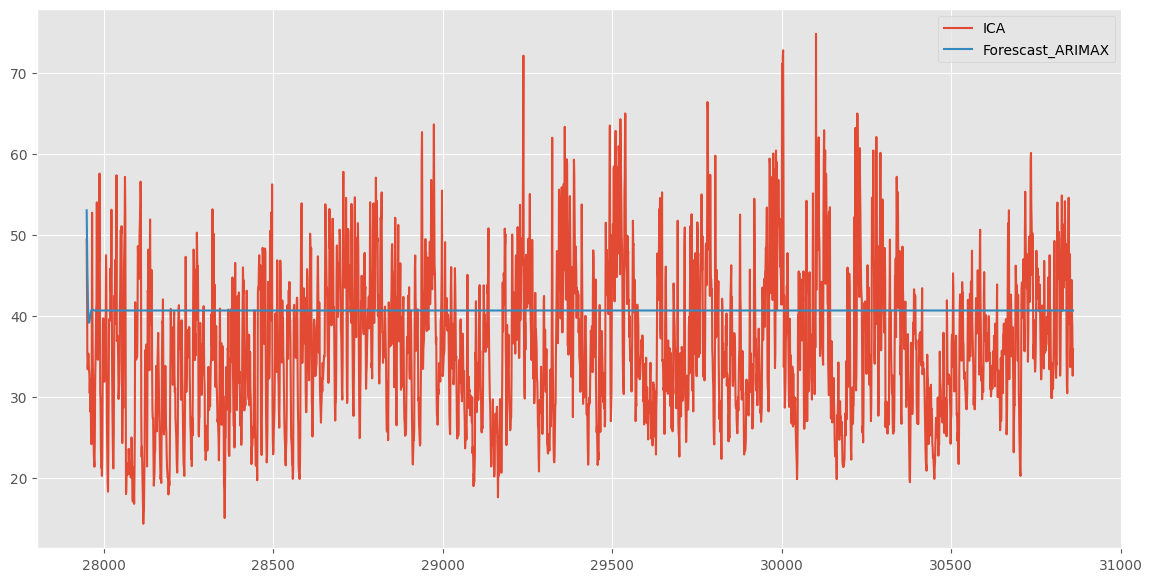

In [25]:
df_valid[['ICA','Forescast_ARIMAX']].plot(figsize=(14,7))

In [26]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [27]:
print('RMSE of Auto ARIMAX:', np.sqrt(mean_squared_error(df_valid.ICA, df_valid.Forescast_ARIMAX)))
print('MAE of Auto ARIMAX:', mean_absolute_error(df_valid.ICA, df_valid.Forescast_ARIMAX))

RMSE of Auto ARIMAX: 10.092227847588163
MAE of Auto ARIMAX: 8.343603845999894


In [28]:
stepwise_model = auto_arima(df.ICA, exogenous = df_train[exogenous_features], trace=True, error_action='ignore', suppress_warnings=True)
#model.fit(df.ICA,exogenous = df_train[exogenous_features])
# stepwise_model = auto_arima(df['ICA'],star_p=1, start_q=1,
#                             max_p=3, max_q=3, m=6,
#                             start_P=0, seasonal=True,
#                             d=1, D=1, trace=True,
#                             error_action='ignore', 
#                             suppress_warnings=True,
#                             stepwise=True)
# model = auto_arima(df_train.ICA, exogenous = df_train[exogenous_features], trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=196145.706, Time=10.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=199866.778, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=199687.006, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=199659.293, Time=1.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=199864.778, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=7.78 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=196263.926, Time=9.31 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=196245.878, Time=18.19 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=13.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=199618.888, Time=2.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=196271.437, Time=6.35 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=196193.273, Time=9.08 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=196145.445, Time=14.50 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=196217.505, Time=19.52 sec
 ARIMA(3,1,4)(

In [29]:
model.fit(df_train.ICA, exogenous=df_train[exogenous_features])

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [30]:
forescast = model.predict(n_periods=len(df_valid),exogenous=df_valid[exogenous_features])
df_valid['Forescast_ARIMA'] = forescast

<Axes: >

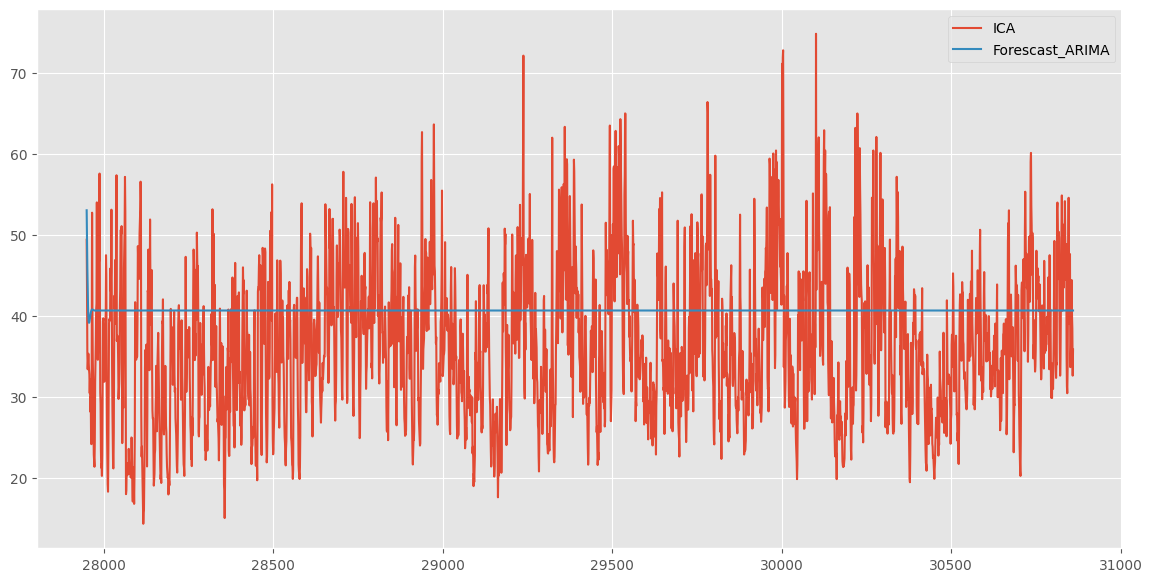

In [31]:
df_valid[['ICA', 'Forescast_ARIMA']].plot(figsize=(14,7))

In [32]:
stepwise_model.fit(df_train.ICA, exogenous=df_train[exogenous_features])

ARIMA(order=(2, 1, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [33]:
forescast2 = model.predict(n_periods=len(df_valid),exogenous=df_valid[exogenous_features])
df_valid['Forescast_SARIMAX'] = forescast2

<Axes: >

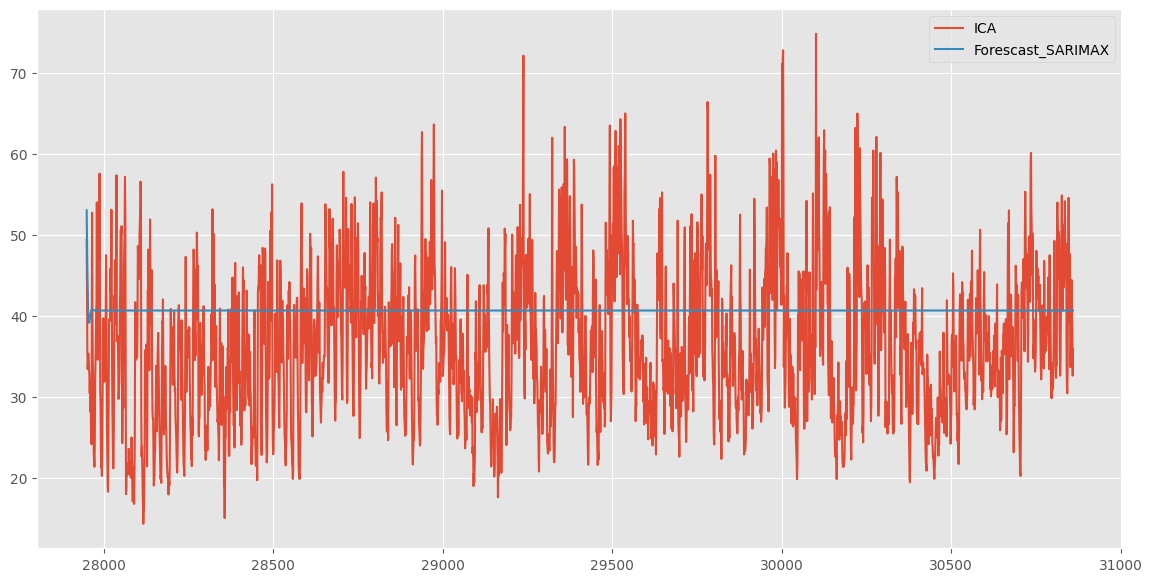

In [34]:
df_valid[['ICA', 'Forescast_SARIMAX']].plot(figsize=(14,7))

In [35]:
print('RMSE of Auto SARIMAX:', np.sqrt(mean_squared_error(df_valid.ICA, df_valid.Forescast_SARIMAX)))
print('MAE of Auto SARIMAX:', mean_absolute_error(df_valid.ICA, df_valid.Forescast_SARIMAX))

RMSE of Auto SARIMAX: 10.092227847588163
MAE of Auto SARIMAX: 8.343603845999894


## Importación principales librerias

In [36]:
import numpy as np
import pandas as pd

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import time
import itertools
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

warnings.filterwarnings("ignore")

## Importación de datos

In [56]:
df = pd.read_csv('../data/calidad_clean_outliers.csv', delimiter=',')
df = df[['FECHA', 'ICA']]
df["ICA_LOG"] = df["ICA"].apply(np.log)
df["ICA_LOG_diff"] = df["ICA_LOG"].diff() #Resta el valor del año anterior en este caso (siempre la fecha anterior a la que indiques)
#df["FECHA"] = pd.to_datetime(df["FECHA"], format = "%Y")
df["FECHA"] = pd.to_datetime(df["FECHA"], format="%Y-%m-%d %H:%M:%S")
df.set_index("FECHA", inplace = True)
df.dropna(inplace = True, axis = "rows")
df.head(2)

,ICA,ICA_LOG,ICA_LOG_diff
FECHA,,,
2019-01-01 06:00:00,45.64,3.820785,0.009245
2019-01-01 07:00:00,47.94,3.869950,0.049166


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30859 entries, 2019-01-01 06:00:00 to 2023-05-31 23:00:00
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ICA           30859 non-null  float64
 1   ICA_LOG       30859 non-null  float64
 2   ICA_LOG_diff  30859 non-null  float64
dtypes: float64(3)
memory usage: 964.3 KB


## Análisis exploratorio de datos

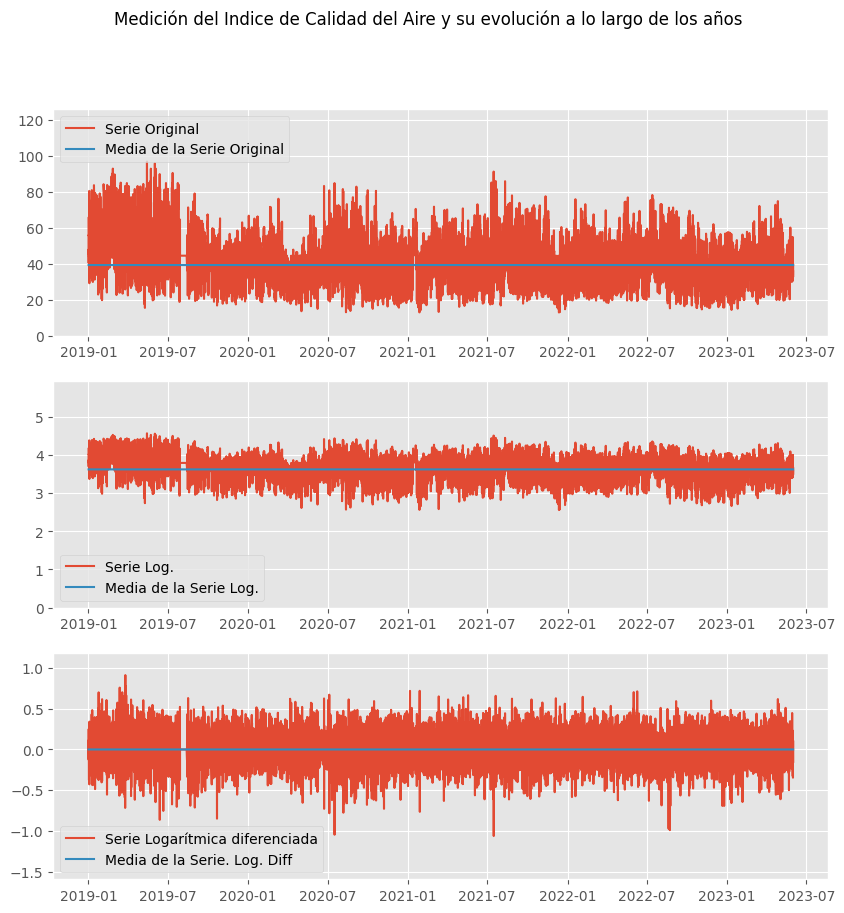

In [58]:


# separar x y la y para el gráfico
x = df.index

y = df["ICA"]
y_media = [np.mean(y) for _ in y]

y_log = df["ICA_LOG"]
y_log_media = [np.mean(y_log) for _ in y_log]

y_log_diff = df["ICA_LOG_diff"]
y_log_diff_mean = [np.mean(y_log_diff) for _ in y_log_diff]

# visualización de los datos anteriores a los largo de los años
fig = plt.figure(figsize = (10, 10))
ax1, ax2, ax3 = fig.subplots(3, 1)

# la serie original parece ser no estacionaria
# si nos fijamos en su comportamiento, vemos muchos picos y que la media de diferentes
# tramos de la serie es diferente.
# además la covarianza entre diferentes tramos también parece distinta.
ax1.plot(x, y, label = "Serie Original")
ax1.plot(x, y_media, label = "Media de la Serie Original")
ax1.set_ylim(0, np.max(y)*1.3)
ax1.legend(loc = "upper left")

# Si transformamos la serie utilizando el logaritmo neperiano (ln)
# tenemos una serie que YA es estacionaria en media y que oscila entorno
# a 7.
ax2.plot(x, y_log, label = "Serie Log.")
ax2.plot(x, y_log_media, label = "Media de la Serie Log.")
ax2.set_ylim(0, np.max(y_log)*1.3)
ax2.legend(loc = "lower left")

# Si aplicamos una diferenciación a al serie logarítmica, seguimos teniendo
# una serie estacionaria, pero esta vez, la media de la serie oscila entorno al cero.

# La diferenciación de una serie estacionaria SIEMPRE da lugar a otra serie estacionaria.
# Por este motivo, no haría falta hacer la diferencia y con la serie transformada (logarítmica)
# es suficiente.

ax3.plot(x, y_log_diff, label = "Serie Logarítmica diferenciada")
ax3.plot(x, y_log_diff_mean, label = "Media de la Serie. Log. Diff")
ax3.set_ylim(np.min(y_log_diff)*1.5, np.max(y_log_diff)*1.3)
ax3.legend(loc = "lower left")

fig.suptitle("Medición del Indice de Calidad del Aire y su evolución a lo largo de los años");



## Comprobación de la estacionaridad de la serie

In [59]:
for serie, nombre_serie in zip([y, y_log, y_log_diff], ["Serie Original", "Serie Log.", "Serie. Log. Diff"]):
    
    print("------------------------------------------------------------------")
    
    print("Estamos trabajando con la serie {}\n".format(nombre_serie))
    resultado_analisis = adfuller(serie)
    
    valor_estadistico_adf = resultado_analisis[0]
    p_valor = resultado_analisis[1]
    
    print("Valor estadistico de ADF de las tablas precalculadas: {}".format(-2.89))
    print("Valor estadistico de ADF: {}\n".format(valor_estadistico_adf))
    
    print("Nivel de significación para tomar la serie como estacionaria {}".format(0.05))
    print("p-valor: {}\n".format(p_valor))

------------------------------------------------------------------
Estamos trabajando con la serie Serie Original

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -13.673183787467877

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 1.4466708364772124e-25

------------------------------------------------------------------
Estamos trabajando con la serie Serie Log.

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -13.992019518661182

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 4.0007323684345517e-26

------------------------------------------------------------------
Estamos trabajando con la serie Serie. Log. Diff

Valor estadistico de ADF de las tablas precalculadas: -2.89
Valor estadistico de ADF: -37.56492057107414

Nivel de significación para tomar la serie como estacionaria 0.05
p-valor: 0.0



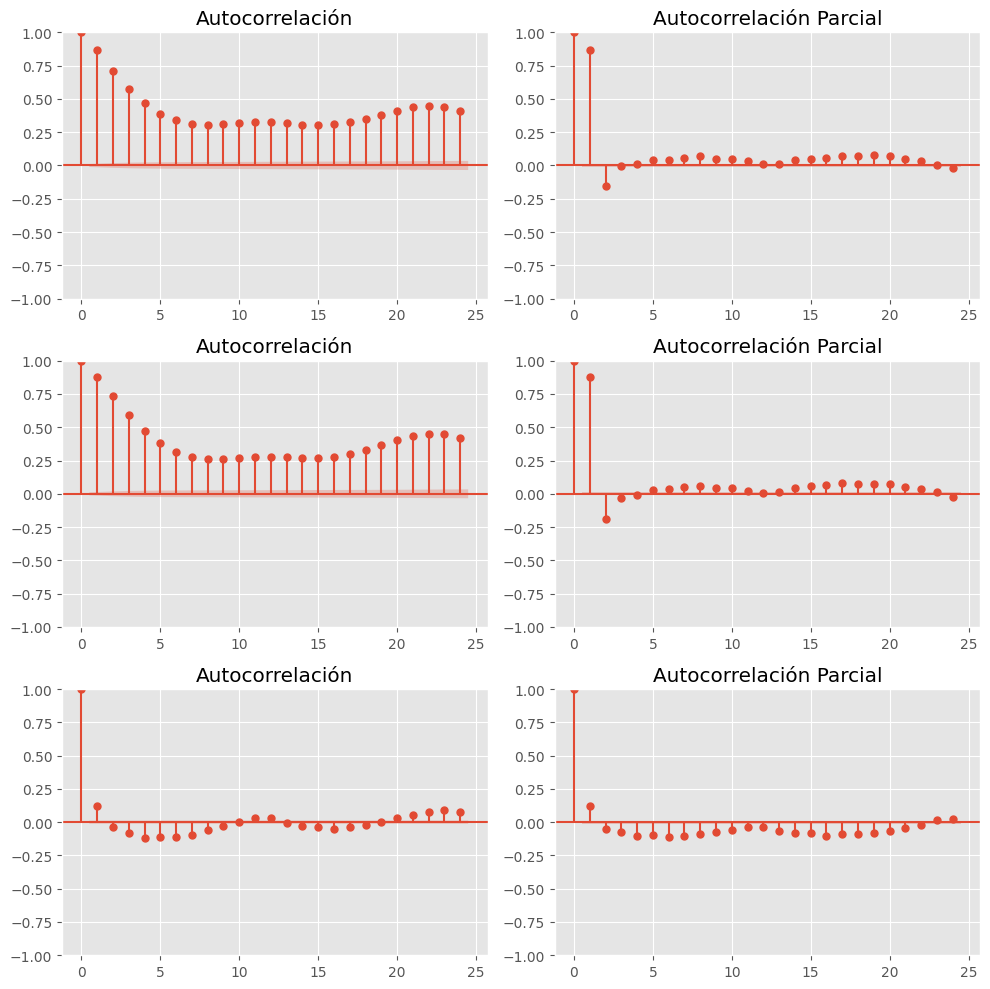

In [60]:
LAGS = 24

fig = plt.figure(figsize = (10, 10))

((ax1, ax2), (ax3, ax4), (ax5, ax6)) = fig.subplots(3, 2)

# ----------------------------------------------------------------------------------------------------
# plot the data using the built in plots from the stats module
plot_acf(y, ax = ax1, lags = LAGS, title = "Autocorrelación")
plot_pacf(y, ax = ax2, lags = LAGS, title = "Autocorrelación Parcial")

plot_acf(y_log, ax = ax3, lags = LAGS, title = "Autocorrelación")
plot_pacf(y_log, ax = ax4, lags = LAGS, title = "Autocorrelación Parcial")

plot_acf(y_log_diff, ax = ax5, lags = LAGS, title = "Autocorrelación")
plot_pacf(y_log_diff, ax = ax6, lags = LAGS, title = "Autocorrelación Parcial")

fig.tight_layout()



Si nos fijamos en los gráficos que obtenemos, vemos que hay para la serie y_log, el gráfico de autocorrelación parcial (segunda fila a la derecha) tiene 3 valores por encima del área sombreada por tanto estos valores son significativamente distintos de cero. Podemos suponer analizando esta serie que el proceso estocástico que ha generado la serie es un AR(2).

Ahora bien, también si analizamos conjuntamente con el ACF (gráficos a la izquierda) vemos que el 3 valor es próximo a área sombreada y por tanto, podemos sugerir otro proceso que haya podido generar este serie como un ARMA(2, 0).

Tal y como sugiere la metodología Box - Jenkins: en la fase de análisis de los ACF y PACF, tenemos que "acotar" los posibles modelos que hayan podido generar la serie siempre optando por el más sencillo de todos.

En la fase de identificación y estimación de paramétros, también podemos calcular el parámetro δ (delta) que vendría a ser la constante del modelo o la media.


## Separación train y test

In [61]:
serie_a_predecir = y_log

In [62]:
y_index = serie_a_predecir.index

date_train = int(len(y_index)*0.9)

y_train = serie_a_predecir[y_index[:date_train]]
y_test = serie_a_predecir[y_index[date_train:len(y_index)]]

In [44]:
y_train.tail()

FECHA
2022-12-22 06:00:00    3.565581
2022-12-22 07:00:00    3.359333
2022-12-22 08:00:00    3.087399
2022-12-22 09:00:00    2.783776
2022-12-22 10:00:00    2.940220
Name: ICA_LOG, dtype: float64

In [63]:
y_test.head()

FECHA
2022-12-22 11:00:00    3.595118
2022-12-22 12:00:00    3.537475
2022-12-22 13:00:00    3.465111
2022-12-22 14:00:00    3.484312
2022-12-22 15:00:00    3.547892
Name: ICA_LOG, dtype: float64

## Gridsearch: Búsqueda de los parámetros óptimos para el modelo ARIMA

In [64]:
# Para hacer el gridsearch, vamos a calcular los posibles valores que vamos a pasarle al modelo.
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

# Vamos a utilizar el modelo SARIMAX, porque en su implementaciòn en Python existen herramientas adicionales
# que nos facilitan el análisis y que no están disponibles en la implementación de ARIMA.

# Ahora bien, SARIMAX es un modelo ARIMA pero con un componente estacional (la leta S de Seasonal) y también
# un componente exógeno (X de eXogenous regressors)
# Por tanto un modelo SARIMAX de (1, 1, 1) x (0, 0, 0, 0)
# Es un modelo ARIMA (1, 1, 1)

# En caso de querer probar un modelo SARIMAX completo, ejecutar la siguiente línea de itertools.
# seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Los dejamos a cero para sólo analizar un modelo ARIMA.
seasonal_pdq = [(0, 0, 0, 0)]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[0]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 0)
SARIMAX: (0, 1, 0) x (0, 0, 0, 0)


Como hemos visto en la sesión teórica, un modelo ARIMA se repsenta como ARIMA (p, d, q) donde:

AR (p): representa la parte "Autorregresiva" del modelo. La intuición básica consiste en que los valores pasados más próximos al momento "t", tendrán mayor impacto en los valores presentes. Para determinar el orden "p" del modelo, podemos utilizar el plot de autocorrelación parcial

I (d): representa la parte "Integral" del modelo y este parámetro del modelo nos dice cuantos diferenciaciones (restas de la serie contra si misma) se tienen que llevar a cabo para convertir la serie en estacionaria.

MA (q): representa la parte de "Medias Móviles". Como vimos, esto implica que el error del modelo se establece como una combinaciòn lineal de los errores observados en el pasado. Para determinar el orden "q" del modelo, podemos utilizar el plot de autocorrelación.

El modelo básico de ARIMA se puede extender más alla incorporando la estacionalidad de la serie y variables exógenas. En este caso estaríamos hablado del modelo SARIMAX representado por (p, d, q) x (P, D, Q) S: donde los parámetros (P, D, Q) representan la misma idea que los (p, d, q) pero tratan sobre la parte estacional de la serie.

El parámetro S a su vez representa el número de periodos que tienen que pasar para que la estacionalidad se repita: 12 para meses, 4 para trimestres etc.

A continuación utilizaremos una "Gridsearch" básico para buscar los parámetros óptimos del modelo ARIMA.

In [65]:
st = time.time()

best_score = 0
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # guardamos el mejor resultado
            if best_score == 0:
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                
            elif abs(results.aic) < abs(best_score):
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
            
        # alguna combinación de parámetros en SARIMAX, no son válidos
        # y los vamos a cazar con un except
        except:
            continue

et = time.time()

print("La búsqueda de parámetros no ha llevado {} minutos!".format((et - st)/60))

ARIMA(0, 0, 0)x(0, 0, 0, 0)12 - AIC:150674.20398191683
ARIMA(0, 0, 1)x(0, 0, 0, 0)12 - AIC:113518.83806903003
ARIMA(0, 0, 2)x(0, 0, 0, 0)12 - AIC:88304.70812662836
ARIMA(0, 1, 0)x(0, 0, 0, 0)12 - AIC:-27142.208153480646
ARIMA(0, 1, 1)x(0, 0, 0, 0)12 - AIC:-27626.93400341971
ARIMA(0, 1, 2)x(0, 0, 0, 0)12 - AIC:-27627.766161304164
ARIMA(0, 2, 0)x(0, 0, 0, 0)12 - AIC:-11706.272576066684
ARIMA(0, 2, 1)x(0, 0, 0, 0)12 - AIC:-27126.069388829346
ARIMA(0, 2, 2)x(0, 0, 0, 0)12 - AIC:-27611.124632510586
ARIMA(1, 0, 0)x(0, 0, 0, 0)12 - AIC:-27153.60366686586
ARIMA(1, 0, 1)x(0, 0, 0, 0)12 - AIC:-27641.499374588766
ARIMA(1, 0, 2)x(0, 0, 0, 0)12 - AIC:-27641.821845946677
ARIMA(1, 1, 0)x(0, 0, 0, 0)12 - AIC:-27601.507437446828
ARIMA(1, 1, 1)x(0, 0, 0, 0)12 - AIC:-27627.330938260973
ARIMA(1, 1, 2)x(0, 0, 0, 0)12 - AIC:-30223.175478826925
ARIMA(1, 2, 0)x(0, 0, 0, 0)12 - AIC:-16819.729411319648
ARIMA(1, 2, 1)x(0, 0, 0, 0)12 - AIC:-27584.856945342464
ARIMA(1, 2, 2)x(0, 0, 0, 0)12 - AIC:-27611.59021892273


El índice de AIC es Akaike Information Criterion y sirve para elegir un modelo entre un conjunto de posibles modelos.

El índice calcula la distancia de Kullback - Leibler entre el modelo y la serie.

Una forma de interpretar el índice es: buscamos el modelo con el menor índice porque este es el más simple que se ajusta a los datos.

In [66]:
print("El mejor modelo es {}, \nCon un AIC de {}".format(best_params, best_score))

El mejor modelo es (0, 2, 0), 
Con un AIC de -11706.272576066684


In [68]:
# Entrenamos el modelo con los mejores parametros.

mod = sm.tsa.statespace.SARIMAX(y_train,
                                order = best_params,
                                seasonal_order = param_seasonal,
                                enforce_stationarity = False,
                                enforce_invertibility = False)

results = mod.fit()

## Interpretación del mejor modelo

In [69]:
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0384      0.000    182.262      0.000       0.038       0.039


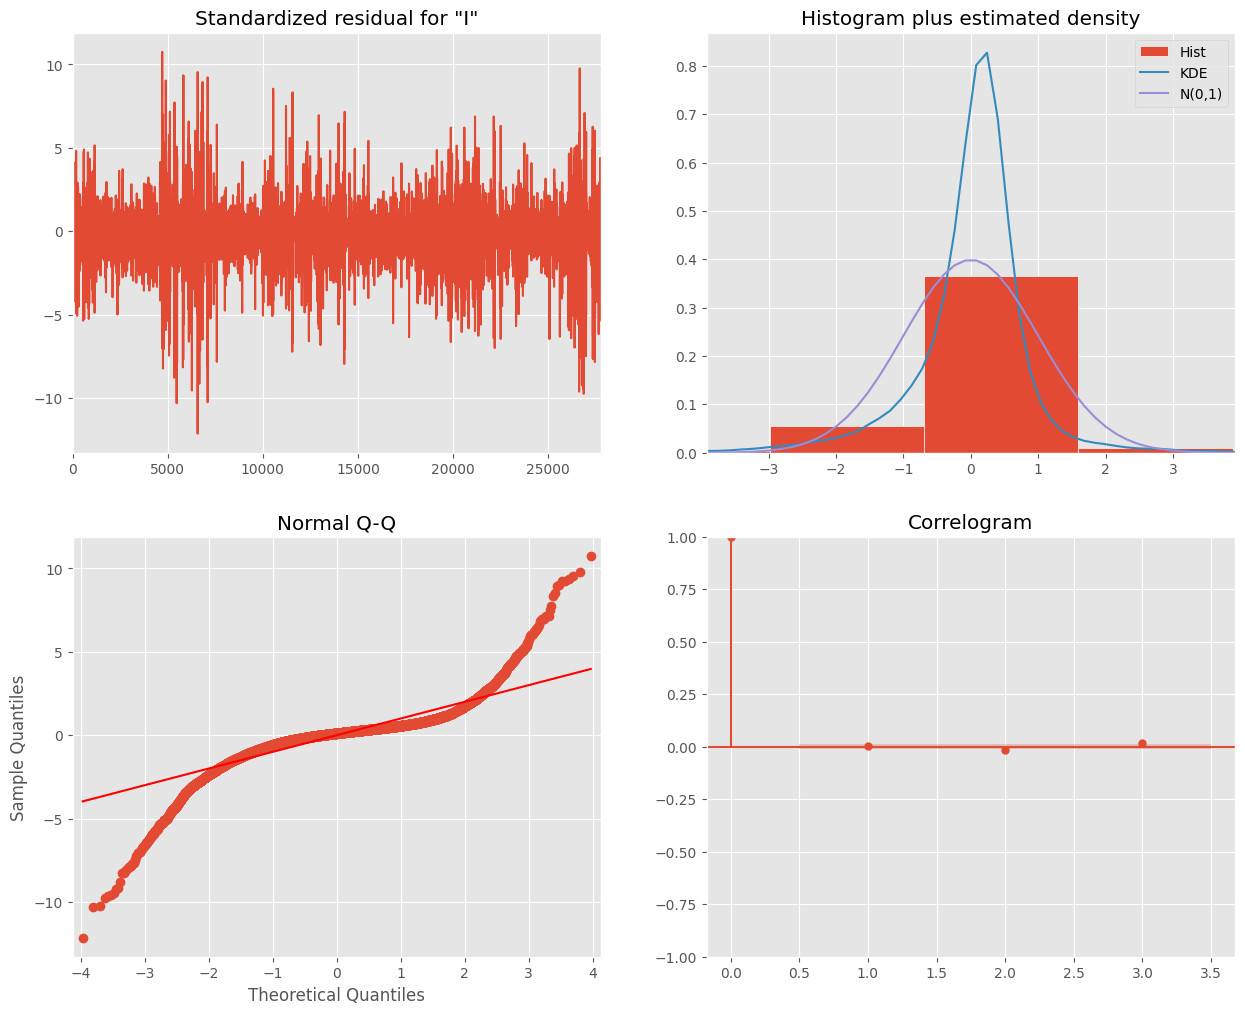

In [51]:
results.plot_diagnostics(figsize = (15, 12), lags = 3);

Interprentado los gráficos podemos observar lo siguiente:

    Arriba a la izquiera: los residuos del modelo parece que siguen un proceso de Ruido Blanco (White Noise) y no son predecibles. Esto implica que nuestro modelo ha extraído toda la información de los datos.
    Arriba a la derecha: vemos que la distribución de los residuos sigue una distribución próxima a la Normal (0, 1).
    Abajo a la derecha: vemos que la autocorrelación parcial entre los residuos y residuos - k, dan lugar a valores no significativos. Esto implica que no "nos queda" información a extraer de los residuos, es decir el modelo no ha sido capaz de reproducir el patrón de comportamiento sistemático de la serie y habría que reformularlo.
    Abajo a la izquierda: la distrbución ordenada de los residuos sigue una Normal.

## Predicción utilizando el modelo

In [70]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = results.get_forecast(steps = len(y_test))

# Calcula el intervalo de confianza de la predicción.
pred_ci = pred_uc.conf_int()

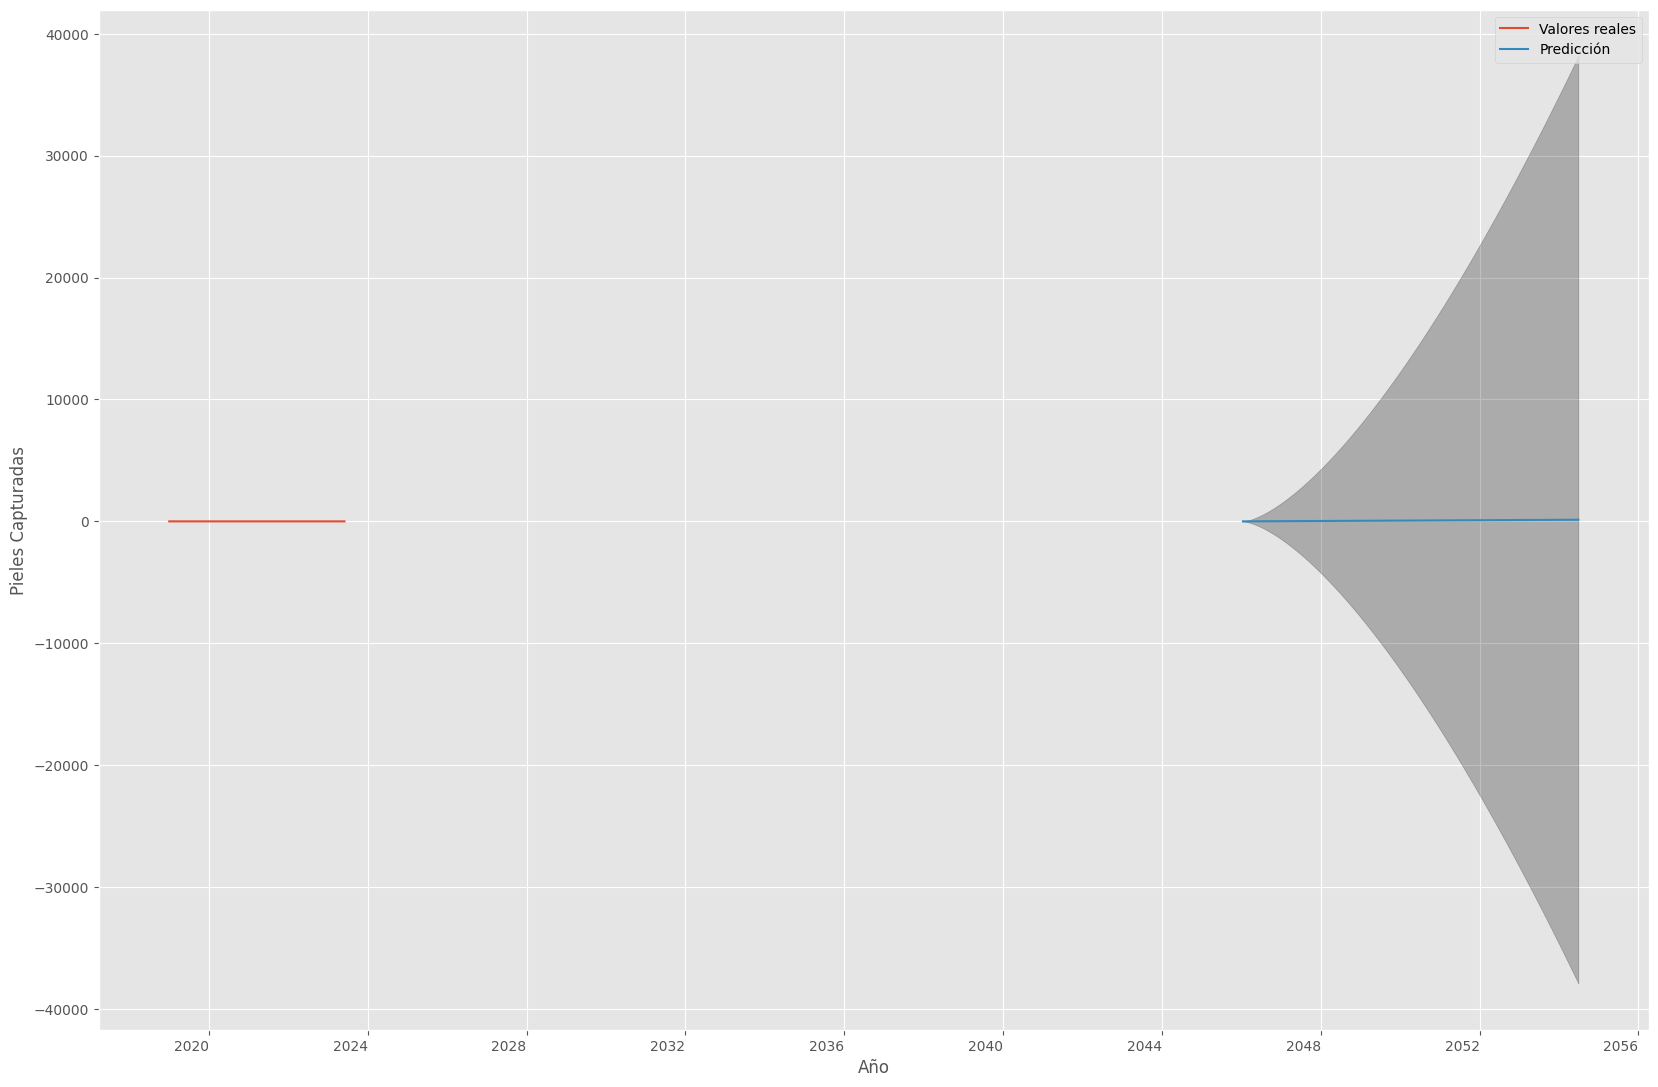

In [71]:
ax = serie_a_predecir.plot(label = 'Valores reales', figsize = (20, 15))

pred_uc.predicted_mean.plot(ax = ax, label = 'Predicción')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)

ax.set_xlabel('Año')
ax.set_ylabel('Pieles Capturadas')

plt.legend()
plt.show()

In [72]:
y_pred = pred_ci.iloc[:, 0]

In [73]:
# El RMSE es de 2.52
rmse = sqrt(metrics.mean_squared_error(y_test, y_pred))

print("El modelo ARIMA con los parametros {}, ha dado un rmse en test de {}".format(best_params, round(rmse, 2)))

El modelo ARIMA con los parametros (0, 2, 0), ha dado un rmse en test de 18943.67
